author: @SteveEckel

This little script tests damped Rabi flopping as calculated with the optical
Bloch equations for a three level system and calculates the three-level susceptibility
to demonstrate EIT.

Notation used within:
```
      ---- |e>



            ---- |r>
  ---- |g>

```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

### Defining the problem.

We'll put the detuning into the Hamiltonian rather than the laser beams.

In [2]:
# First, define the lasers (functionalized for later):
Ige = 4; Ire = 4; Delta = -2; delta = 0.
def return_three_level_lasers(Ige, Ire):
    laserBeams = {}
    laserBeams['g->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ige}],
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    laserBeams['r->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ire}],                           
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    return laserBeams

laserBeams = return_three_level_lasers(Ige, Ire)

# Second, magnetic field:
magField = lambda R: np.zeros(R.shape)

# Now define the Hamiltonian (functionaized for later):
H0 = np.array([[1.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0,] = 1/np.sqrt(2)

def return_three_level_hamiltonian(Delta, delta):
    hamiltonian = pylcp.hamiltonian()
    hamiltonian.add_H_0_block('g', 0.*H0)
    hamiltonian.add_H_0_block('r', delta*H0)
    hamiltonian.add_H_0_block('e', Delta*H0)
    hamiltonian.add_d_q_block('g','e', d_q)
    hamiltonian.add_d_q_block('r','e', d_q)

    return hamiltonian

hamiltonian = return_three_level_hamiltonian(Delta, delta)
hamiltonian.print_structure()

[[(<g|H_0|g> 1x1) None (<g|d_q|e> 1x1)]
 [None (<r|H_0|r> 1x1) (<r|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) (<e|d_q|r> 1x1) (<e|H_0|e> 1x1)]]


### Set up the OBE

We'll first set up some damped Rabi oscillations in the three-level system.

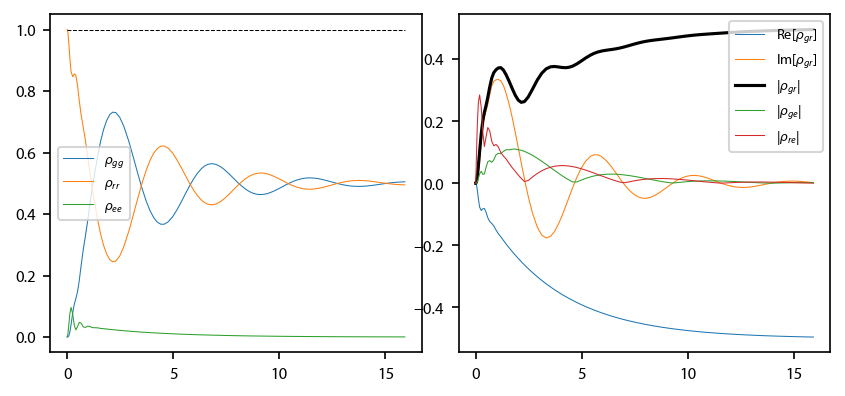

In [3]:
obe = pylcp.obe(laserBeams, magField, hamiltonian,
                transform_into_re_im=True)
obe.set_initial_rho_from_populations(np.array([0., 1., 0.]))
obe.evolve_density([0, 100])

fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 0]), linewidth=0.5, label='$\\rho_{gg}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[1, 1]), linewidth=0.5, label='$\\rho_{rr}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[2, 2]), linewidth=0.5, label='$\\rho_{ee}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 0]+obe.sol.rho[1, 1]+obe.sol.rho[2, 2]), 'k--', linewidth=0.5)
ax[0].legend(fontsize=7)

ax[1].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 1]), linewidth=0.5,
           label='Re$[\\rho_{gr}]$')
ax[1].plot(obe.sol.t/2/np.pi, np.imag(obe.sol.rho[0, 1]), linewidth=0.5,
           label='Im$[\\rho_{gr}]$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 1]), 'k-',
           label='$|\\rho_{gr}|$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 2]), linewidth=0.5, label='$|\\rho_{ge}|$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[1, 2]), linewidth=0.5, label='$|\\rho_{re}|$')
ax[1].legend(fontsize=7)

### Susceptibility and EIT

Note that the susceptibility is porportional to $\rho_{re}$:

In [4]:
Deltas = np.array([-5., -1., -0.1])
deltas = np.arange(-7., 7., 0.1)
delta_random = np.random.choice(deltas)

include_random_sol = False

it = np.nditer(np.meshgrid(Deltas, deltas)+ [None,])

laserBeams = return_three_level_lasers(1, 0.1)
for Delta, delta, rhore in it:
    hamiltonian = return_three_level_hamiltonian(Delta, delta)
    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                        transform_into_re_im=True)
    obe.set_initial_rho_from_populations([0, 1, 0])
    obe.evolve_density([0, 2*np.pi*5])

    rhore[...] = np.abs(obe.sol.rho[1, 2, -1])

Plot it up:

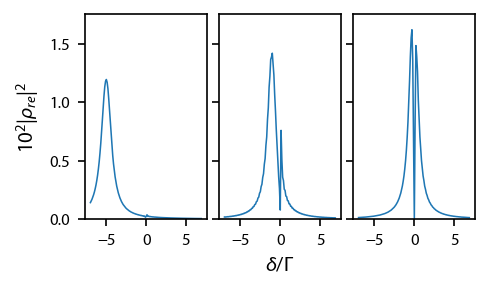

In [5]:
if include_random_sol:
    fig, ax = plt.subplots(3, 1, figsize=(3.75, 2.5*3))
else:
    fig, ax = plt.subplots(1, 3, figsize=(3.25, 1.75))
    
if include_random_sol:
    ax[0].plot(deltas, it.operands[2]**2, linewidth=0.75)
    ax[0].set_ylabel('$|\\rho_{re}|^2$')
    ax[0].set_xlabel('$\delta/\Gamma$')

    ax[0].plot([delta_random, delta_random], [0, np.amax(it.operands[1])**2], 'k-')
    ax[2].set_xlabel('$\Gamma t/(2\pi)$')
    fig.subplots_adjust(hspace=0.25)
    
    for Delta, delta, rhore in it:
        ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 0]),
                   linewidth=0.5, label='$|\\rho_{gg}|$')
        ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[1, 1]),
                   linewidth=0.5, label='$|\\rho_{rr}|$')
        ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[2, 2]),
                   linewidth=0.5, label='$|\\rho_{ee}|$')
        ax[1].legend(fontsize=7)

        ax[2].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[1, 2]),
                   linewidth=0.5, label='$|\\rho_{ge}|$')
        ax[2].plot(obe.sol.t/2/np.pi, np.imag(obe.sol.rho[1, 2]),
                   linewidth=0.5, label='$|\\rho_{re}|$')
        ax[2].legend(fontsize=7)
else:
    for ii, row in enumerate(it.operands[2].T):
        ax[ii].plot(deltas, 1e2*row**2, linewidth=0.75)
        ax[ii].set_ylim(0, 1.75)
        if ii>0:
            ax[ii].yaxis.set_ticklabels('')
    ax[0].set_ylabel('$10^2|\\rho_{re}|^2$')
    ax[1].set_xlabel('$\delta/\Gamma$')
    
    fig.subplots_adjust(bottom=0.2)

In [6]:
fig.savefig('eit_susceptibility.pdf')

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
